In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

$$
\newcommand{\g}{\mathbf{g}}
\newcommand{\remember}{\mathbf{remember}}
\newcommand{\save}{\mathbf{save}}
\newcommand{\focus}{\mathbf{focus}}
\newcommand{\contextcsm}{\mathcal{c}}
\newcommand{\querycsm}{\mathcal{q}}
$$

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
%run beautify_plots.py

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

# From Math to Program

Before introducing more advanced layer types (like the LSTM)
- we want to provide some simple intuition
- for what will appear to be complicated equations that govern these new layer types.

Neural Networks have the flavor of a Functional Program
- A Sequential Model computes the composition of per-layer functions


- Layer $\ll$ is computing a function $\y_\llp  = F_\llp$
$$
\begin{array}[lll]\\
F_\llp( \y_{(\ll-1)}; \W_\llp ) = \y_\llp \\
F_\llp: \mathcal{R}^{|| \y_{(\ll-1)} ||} \mapsto \mathcal{R}^{|| \y_\llp ||} \\
\end{array}
$$

If we expand $F_\llp$, we see that it is 
the $\ll$-fold composition of functions $F_{(1)}, \ldots, F_\llp$
$$
\begin{array}[lll]\\
\y_\llp & = & F_\llp( \y_{(\ll-1)}; \W_\llp ) \\
& = &  F_\llp( \; F_{(\ll-1)}( \y_{(\ll-2)}; \,\W_{(\ll-1)} ); \,\W_\llp \;) \\
& = &  F_\llp( \; F_{(\ll-1)}( \; F_{(\ll-2)}( \y_{(\ll-3)}; \,\W_{(\ll-2)} ); \,\W_{(\ll-1)} \;  ); \W_\llp \;) \\
& = & \vdots \\
\end{array}
$$

It turns out that it is not too difficult to endow a Neural Network with familiar *imperative* programming constructs
- `if` statement
- `switch/case` statement

This is sometimes called *Neural Programming*.

So one way of understanding some complicated equations (e.g., for the LSTM) 
- is to realize that they are encoding "soft" analogs of familiar programming concepts


# Binary switches

When we introduced Neural Networks, we argued that their power derived from the ability of Activation Functions
- To act like binary "switches"
- Converting the scalar value computed by the dot product
- Into a True/False answer
- To the question: "Is a particular feature present" ?


<div>
    <center>Step function: binary switch with threshold 0</center>
    <br>
<img src=images/Step_function_1.jpg>
</div>

By varying the threshold/bias, we can control the region in which the switch is "active"

<div>
    <center>Step function: binary switch with threshold - x^(i)</center>
    <br>
<img src=images/Step_function_2.jpg>
</div>

And, in fact, we [showed](Universal_Function_Approximator.ipynb)
how to construct a very precise approximation of a binary switch:

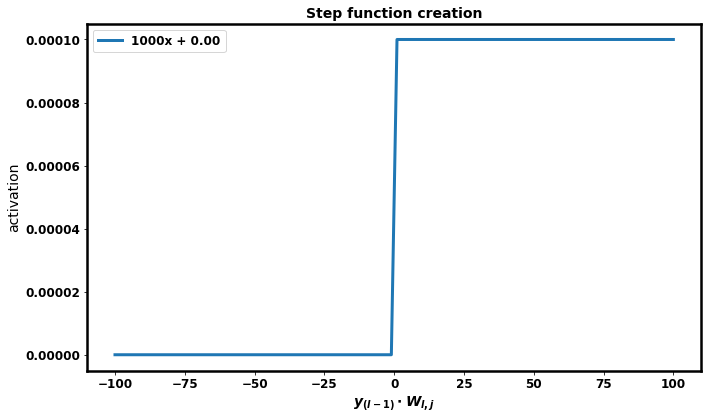

In [5]:
fig, ax = nnh.step_fn_plot()

# Neurons as statements

With the ability to implement a binary switch
- We can construct Neural Networks
- With elements that look like primitive statements of a programming language

Rather than building a true step function
- We will settle for the approximation offered by the Sigmoid function $\sigma$


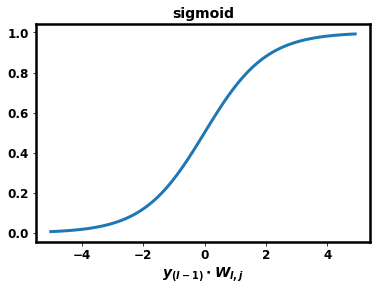

In [6]:
_= nnh.sigmoid_fn_plot()

This is more than laziness or convenience
- The step function is **not** differentiable
- The sigmoid function **is** differentiable

Recall that Gradient Descent is the tool we use to train Neural Networks
- Hence it is important that our functions be differentiable !

Thus the switches (analogous to conditions in an `if` statement)
- Will not output one of True/False
- But rather a "soft" approximations

## "If" statements - Gates

Suppose we want a Neural Network to
- Compute a (vector) output $\y$
- That takes on vector value $T$ if some condition $g$ is `True`
- And $F$ otherwise.

This would be trivial in any programming language having an `if` statement:

`if (g):
    y = T
else:
    y = F
    `

Let's show how to construct the `if` statement with just a little arithmetic.

Suppose scalar $g \in \{ 0, 1 \}$ was the value output by a switch.

Then 
$$
\begin{array}[ll]\\
\y = (g * \mathbf{T}) + (1 - g ) * \mathbf{F} \\
\end{array}
$$

does the trick.

In general, we tend to compute vectors rather than scalars.

Let
- $\g, \y$ be vectors of equal length
- $\mathbf{T}, \mathbf{F}$ be vectors of equal length (not necessarily the same as $\g, \y$)
    - So elements of $\y$ have length $|| \mathbf{T} || = || \mathbf{F} ||$
 

We will construct a "vector" `if` statement
- Making a conditional choice for *each element* of $\y$, independently.
$$
\y_j = (\g_j * \mathbf{T}) + (1 - \g_j) * \mathbf{F}
$$

Letting
- $\otimes$ denote element-wise vector multiplication (*Hadamard product*)
- $\sigma( \ldots )$ be a sigmoid approximation of a binary switch

The following product (almost) does the trick

$$
\begin{array}[ll]\\
\g = \sigma( \ldots ) \\
\y = \g \otimes \mathbf{T} + (1 - \g ) \otimes \mathbf{F} \\
\end{array}
$$

It is only "almost"
- Because the sigmoid only takes a value in the range $[0,1]$
- Rather than exactly either $0$ or $1$

So $\g$ is a "soft" condition rather than a hard (either True or False) condition.
- This means that $\y$ will be a blend of $\mathbf{T}$ and $\mathbf{F}$

What we have is
- A continuous (soft) decision $\g$.
- That creates a vector `if`
- Whose elements are *mixtures* of $\mathbf{T}$ and $\mathbf{F}$

This is the price we pay for having $\g$ be differentiable !

Note that the individual elements of vector $\y$ are independent
- $\y_j$ is influenced only by $\g_j$
- The synthetic features represented by $\y$ are not dependent on one another.
- Most importantly: the derivatives of each feature are independent

## "Switch/Case" statements 

We can easily generalize from a two-case `if` to a `switch/case` statement with $|| \mathbf{C} ||$ cases.

Suppose we need to set $\y$ to one value from among multiple choices in $\mathbf{C}$

$$
\begin{array}[ll]\\
\g = \text{softmax}( \ldots ) \\
\y = \g \otimes \mathbf{C}  \\
\end{array}
$$

The *softmax* function
- Was introduced in Multinomial Classification
- Computes a vector (of length $|| C ||$) values
- With each element being in the range $[0,1]$
- And summing to $1$


We refer to $\g$ as a *mask* for $\mathbf{C}$.


The `if` statement is a special case of the `switch/case` statement where

$$
\mathbf{C} = \left[
 \begin{matrix}
    \mathbf{T}  \\
    \mathbf{F}
 \end{matrix} 
 \right] \\
$$


## Soft Lookup

The "approximate case" statement we created has an interesting application:
- A lookup table (`dict` in Python) that does soft matching

Whereas an ordinary `dict` in Python returns an undefined value when the query key $q$ does not match any key in the dictionary
- A soft lookup table $M$ (*context sensitive memory*) returns a *weighted sum* of the values associated with all keys

Context Sensitive Memory $M$ is a set of key/value pairs
$$
M  = \{ (k_{\bar{\tt}}, v_{\bar{\tt}} ) \, | \, 1 \le \bar{\tt} \le \bar{T} \}
$$

A query $\querycsm$
- Is a value from the *same domain* as the keys (e.g., a string or a vector)
- **Not** necessarily matching any  key in $M$


A lookup of query $\querycsm$ into $M$ returns
$$
\text{lookup}(q, M) = \sum_{ (k,v) \in M} { \alpha(q, k) * v }
$$

where the weights $\alpha(\querycsm,k)$ are computed via a Softmax on the value $\text{score}(q, k )$

$$
\alpha(q, k) = \frac{ \exp(\text{score}(q, k) )}{ \sum_{k' \in \text{keys}(M) } { \exp( \text{score}(q, k' ) } }
$$

The value $\text{score}(q, k )$ is a measure of the similarity between query $\querycsm$ and key $k$.
- $\alpha(q, k) $  is sometimes referred to as a *normalized score*.



There are several common choices for the scoring function that measures the similarity between query $\querycsm$ and key $k$:

$$
\text{score}(\querycsm, k) =
\begin{cases}
\querycsm^T \cdot k & \text{dot product, cosine similarity} \\
\querycsm^T \W_\alpha k & \text{general} \\
\v^T_\alpha \tanh(\W_\alpha [ \querycsm; k]) & \text{concat}\\
\end{cases}
$$

All of these are easily implemented with the building blocks of Neural Networks.

# Conclusion

We wanted to show that, in concept
- We could create the logic of a simple imperative program
- Using the machinery of Neural Networks

The only catch was
- We cannot use true binary logic (hard decisions)
- All choices are *soft*
- In order to preserve differentiability
- Which is necessary for training with Gradient Descent

This background will facilitate our explanation of more advanced Layer types.

In [7]:
print("Done")

Done
